# (Generalized) Pattern Lattice Builder (PLB) runner

developed by Kow Kuroda (kow.kuroda@gmail.com)

Creation
- 2024/10/18

Modifications
- added compatibility with package format (2024/10/20)
- implemented automatic figure sizing (2024/10/22)
- implemented robust z-score (2024/10/23)
- implemetend multiprocess-based speeding up at PatternLattice.merge_lattices()
- implemented content tracking (2024/10/31)
- added upper-bound to z-score-based node pruning (2024/11/01)
- renamed to gPLB-runner-on-bare-items.ipynb (2025/09/17)
- added handling of more_generalized, tracing (2025/10/09)
- added handling of layered segmentation (2025/10/28)

In [1]:
## imports
import gPLB as plb

## The following needs to be True only for debugging/development.
re_import_module = True
if re_import_module:
    import importlib
    importlib.reload (plb)

In [2]:
## inspect plb.py
import pprint as pp
content_check = False
if content_check:
    pp.pprint(dir(plb))

In [3]:
## Parameters
## execution verbosity
verbose     = True

## settings for CJK font display
## N.B. phonetic symbols are likely to be incompatible with CJK-ready font
use_multibyte_chars = True

## internal variables
comment_escapes  = ['#', '%']
field_seps      = r",;"
sep2_is_suppressive = True # if True, only ";" is used and "," is ignored

## size filtering on input
size_filtering  = False
max_size        = 5

## parameters for PLB
gap_marks      = [ "_", "…" ]
gap_mark       = gap_marks[0]
tracer         = "~"

## if Generalized Pattern Lattice is used nor not
generalities = [ 0, 1, 2 ]
generality    = generalities[2]
print (f"Generality level: {generality}")

## if instantiation check is reflexive
reflexive        = True # Don't change this setting unless you know what you are doing.

## if node pooling is reductive
reductive       = True # Don't change this setting unless you know what you are doing.

## productivity metric
p_metrics  = ['rank', 'gap_size']
p_metric   = p_metrics[0]

## if robust Z-score is used instead of normal Z-score
use_robust_zscore   = True

## select the bases of z-scores: link sources or link targets
zscores_from_targets = False

### settings for drawing
## draw individual lattices
draw_inline                = True # whether to draw inline in Jupyter Notebook
auto_figsizing             = True
draw_individual_lattices   = True
draw_sample_lattices_only  = True
sample_lattice_n           = 3

## full display for merged pattern lattice
draw_full_version_for_merged = False

Generality level: 2


In [4]:
## graph layout selection
graph_layouts = [   'Multi_partite', # 0
                    'Graphviz', # 1
                    'ARF', # 2
                    'Fruchterman_Reingold', # 3
                    'Kamada_Kawai', # 4
                    'Spring', # 5
                    'Circular', # 6
                    'Shell', # 7
                    'Planar', # 8 [often fails to work]
                    # 'Breadth-First Search', # fails work
                 ]
#
graph_layout = graph_layouts[0]
print(f"graph_layout: {graph_layout}")

MPG_keys = ['gap_size', 'rank']
MPG_key = MPG_keys[0]
print(f"MPG_key: {MPG_key}")

graph_layout: Multi_partite
MPG_key: gap_size


In [5]:
## set up font
import matplotlib
from matplotlib import font_manager as Font_manager

if use_multibyte_chars:
    ## select font
    multibyte_font_names = [    "IPAexGothic",  # 0 Multi-platform font
                                "Hiragino sans" # 1 Mac only
                            ]
    multibyte_font_name  = multibyte_font_names[0]
    ## tell where target fonts are
    system_font_dir = "/System/Library/Fonts/"
    user_font_dir = "/Library/Fonts/"
    # use the version installed via TeXLive
    user_font_dir2 = "/usr/local/texlive/2013/texmf-dist/fonts/truetype/public/ipaex/"
    if multibyte_font_name == "IPAexGothic":
        try:
            Font_manager.fontManager.addfont(f"{user_font_dir}ipaexg.ttf")
        except FileNotFoundError:
            Font_manager.fontManager.addfont(f"{user_font_dir2}ipaexg.ttf")
    elif multibyte_font_name == "Hiragino sans":
        Font_manager.fontManager.addfont(f"{system_font_dir}ヒラギノ角ゴシック W0.ttc")
    ## check result
    matplotlib.rc('font', family = multibyte_font_name)
else:
    multibyte_font_name = None
    matplotlib.rcParams['font.family'] = "Sans-serif"
##
print(f"multibyte_font_name: {multibyte_font_name}")
print(f"matplotlib.rcParams['font.family']: {matplotlib.rcParams['font.family']}")    

multibyte_font_name: IPAexGothic
matplotlib.rcParams['font.family']: ['IPAexGothic']


# Preparation

In [6]:
## select target file
data_dir = "data1"
data_names = [  'plb-sample0', 'plb-sample1', 'plb-sample2',
                'plb-inteY-max9', 'plb-inteY-max11',
                'plb-utau-naku-sinu', 'plb-utau-naku-sinu-commented',
                'plb-XiY-max7', 'plb-XiY-max9', 'plb-XiY-wiper2-phonetic', 'plb-XiY-wiper2b', 'plb-XiY-wiper3-dual','plb-XiY-wiper5b-dual'
            ]
data_name = data_names[0]
data_file = f"{data_dir}/{data_name}.csv"
print(f"data_file: {data_file}")

data_file: data1/plb-sample0.csv


In [7]:
## single file
#data_file = "/Users/kowk/Dropbox/Research/FOCAL/New Introduction/sources/plb-sore-ga-kaji-no-geNiN.csv"

In [8]:
## reading data from source
print(f"read data from: {data_file}")
with open(data_file, encoding = "utf-8") as f:
    lines = [ line.strip() for line in f.readlines() if len(line.strip()) > 0 ]
print(lines)

read data from: data1/plb-sample0.csv
['i, n', 'i, n; g', 'p, i; n', 'p; i, n; k', 'p; i, n; g', 's; i, n', 's; i, n; k', 's; i, n; g', 'k; i, n', 'k; i, n; g', 'k; i, n; k', 'w; i, n', 'w; i, n; k', 'w; i, n; g', 'f; u, n', 'f; u, n; k', 'p; u, n', 'p; u, n; k', 'd; u, n; k', 'f; a, n', 'f; a, n; g', 'b; u, d', 'm; u, d']


In [9]:
lines = [ plb.strip_comment(line, comment_escapes) for line in lines ]
print(lines)

['i, n', 'i, n; g', 'p, i; n', 'p; i, n; k', 'p; i, n; g', 's; i, n', 's; i, n; k', 's; i, n; g', 'k; i, n', 'k; i, n; g', 'k; i, n; k', 'w; i, n', 'w; i, n; k', 'w; i, n; g', 'f; u, n', 'f; u, n; k', 'p; u, n', 'p; u, n; k', 'd; u, n; k', 'f; a, n', 'f; a, n; g', 'b; u, d', 'm; u, d']


In [10]:
## layered segmentation of lines
data = [ plb.segment_with_levels(line, seps = field_seps, sep2_is_suppressive = sep2_is_suppressive) for line in lines if len(line) ]

In [11]:
import pprint as pp
pp.pprint(data)

[['in'],
 ['in', 'g'],
 ['pi', 'n'],
 ['p', 'in', 'k'],
 ['p', 'in', 'g'],
 ['s', 'in'],
 ['s', 'in', 'k'],
 ['s', 'in', 'g'],
 ['k', 'in'],
 ['k', 'in', 'g'],
 ['k', 'in', 'k'],
 ['w', 'in'],
 ['w', 'in', 'k'],
 ['w', 'in', 'g'],
 ['f', 'un'],
 ['f', 'un', 'k'],
 ['p', 'un'],
 ['p', 'un', 'k'],
 ['d', 'un', 'k'],
 ['f', 'an'],
 ['f', 'an', 'g'],
 ['b', 'ud'],
 ['m', 'ud']]


# Process individual pattern lattices

In [12]:
## size filter
if size_filtering and not max_size is None:
    data = [ x for x in data if len(x) <= max_size ]

In [13]:
## sampling
sampling      = True
sampling_rate = 0.3
if sampling and len(data) > 10:
      import random
      data = random.sample(data, round(len(data) * sampling_rate))
##
print(f"sampled {len(data)} inputs")
pp.pprint(data)

sampled 7 inputs
[['in'],
 ['m', 'ud'],
 ['p', 'un'],
 ['b', 'ud'],
 ['s', 'in'],
 ['pi', 'n'],
 ['f', 'an']]


In [14]:
## build pattern lattices from data
Lx = [ ]
for item in data:
    pat    = plb.Pattern(item, gap_mark, tracer)
    patlat = plb.PatternLattice(pat, generality = generality, reflexive = reflexive, reductive = reductive)
    if verbose:
        print(patlat)
    Lx.append(patlat)
print(f"Lx contains {len(Lx)} lattices")

PatternLattice ([Pattern ([('_', ['in'])]), Pattern ([('in', ['in'])])])
PatternLattice ([Pattern ([('_', ['m']), ('_', ['ud'])]), Pattern ([('_', ['m']), ('ud', ['ud'])]), Pattern ([('m', ['m']), ('_', ['ud'])]), Pattern ([('m', ['m']), ('ud', ['ud'])])])
PatternLattice ([Pattern ([('_', ['p']), ('_', ['un'])]), Pattern ([('_', ['p']), ('un', ['un'])]), Pattern ([('p', ['p']), ('_', ['un'])]), Pattern ([('p', ['p']), ('un', ['un'])])])
PatternLattice ([Pattern ([('_', ['b']), ('_', ['ud'])]), Pattern ([('_', ['b']), ('ud', ['ud'])]), Pattern ([('b', ['b']), ('_', ['ud'])]), Pattern ([('b', ['b']), ('ud', ['ud'])])])
PatternLattice ([Pattern ([('_', ['s']), ('_', ['in'])]), Pattern ([('_', ['s']), ('in', ['in'])]), Pattern ([('s', ['s']), ('_', ['in'])]), Pattern ([('s', ['s']), ('in', ['in'])])])
PatternLattice ([Pattern ([('_', ['pi']), ('_', ['n'])]), Pattern ([('_', ['pi']), ('n', ['n'])]), Pattern ([('pi', ['pi']), ('_', ['n'])]), Pattern ([('pi', ['pi']), ('n', ['n'])])])
Pattern

In [15]:
## selection of graph layout
layouts = ['Multi_partite', 'Graphviz', 'ARF', 'Fruchterman_Reingold', 'Kamada_Kawai', 'Spring', 'Circular', 'Shell', 'Planar']
layout = layouts[0]
print(f"layout: {layout}")

layout: Multi_partite


In [16]:
## effective only Multi-partite is used
MPG_keys = ['gap_size', 'rank', 'size']
MPG_key = MPG_keys[0]
print(f"MPG_key: {MPG_key}")

MPG_key: gap_size


#pruned/ignored 0 nodes
#n_instances: 1
#max_instance_n_segs: 2
#max_instance_size: 3
#fig_size: None
#label_size: 8
#node_size: 9
#instance_labels 1: ['pi, n']


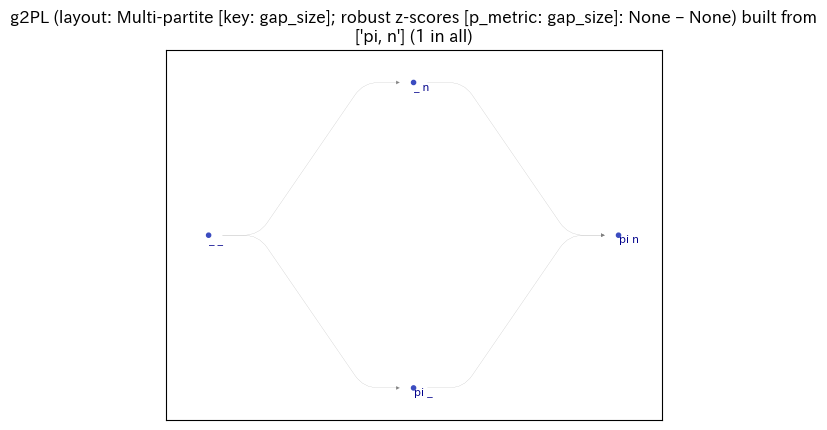

#pruned/ignored 0 nodes
#n_instances: 1
#max_instance_n_segs: 1
#max_instance_size: 2
#fig_size: None
#label_size: 8
#node_size: 9
#instance_labels 1: ['in']


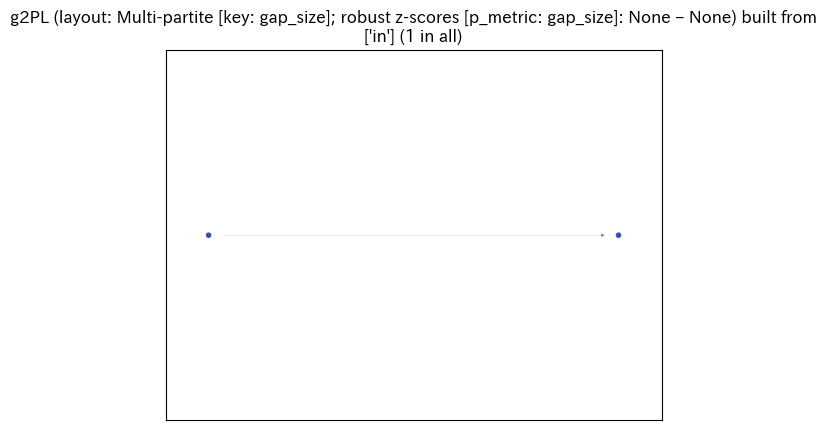

#pruned/ignored 0 nodes
#n_instances: 1
#max_instance_n_segs: 2
#max_instance_size: 3
#fig_size: None
#label_size: 8
#node_size: 9
#instance_labels 1: ['b, ud']


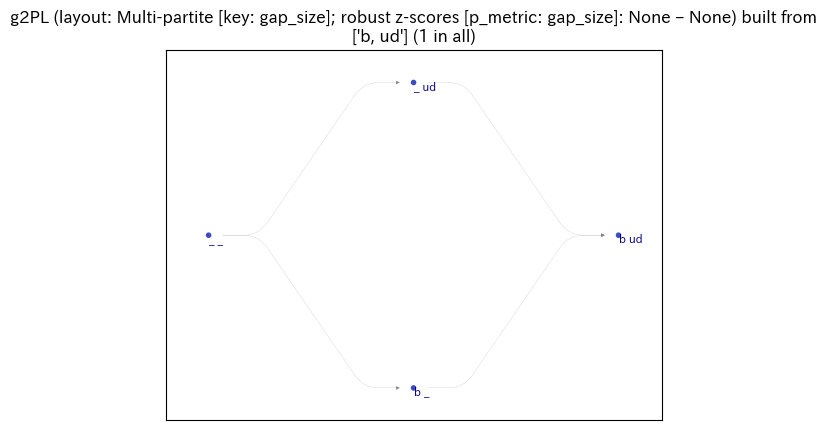

In [17]:
## draw pattern lattices individually
if draw_individual_lattices:
    if draw_sample_lattices_only and len(Lx) > 1:
        Ly = random.sample(Lx, sample_lattice_n)
        for patlat in Ly:
            patlat.draw_lattice (layout, MPG_key, draw_inline = draw_inline, auto_figsizing = False, generality = generality, zscores_from_targets = zscores_from_targets, graphics_backend = None, font_name = multibyte_font_name)
    else:
        for patlat in Lx:
            patlat.draw_lattice (layout, MPG_key, draw_inline = draw_inline, auto_figsizing = True, generality = generality, zscores_from_targets = zscores_from_targets, graphics_backend = None, font_name = multibyte_font_name)

In [18]:
#raise "Stop execution"

# Process merged pattern lattice

In [19]:
## merge pattern lattices
gen_links_internally = True
import functools
M = functools.reduce (lambda La, Lb: La.merge_with (Lb, gen_links_internally = gen_links_internally, generality = generality, reflexive = reflexive, reductive = reductive, use_mp = True, check = False), Lx)

In [20]:
if gen_links_internally:
    print(M.links)
    print(f"M.links has {len(M.links)} links" )

[PatternLink (l: Pattern ([('_', ['in'])]); r: Pattern ([('in', ['in'])]);
type: ), PatternLink (l: Pattern ([('_', ['b']), ('_', ['ud'])]); r: Pattern ([('_', ['in'])]);
type: ), PatternLink (l: Pattern ([('_', ['pi']), ('_', ['n'])]); r: Pattern ([('_', ['in'])]);
type: ), PatternLink (l: Pattern ([('_', ['s']), ('_', ['in'])]); r: Pattern ([('_', ['in'])]);
type: ), PatternLink (l: Pattern ([('_', ['p']), ('_', ['un'])]); r: Pattern ([('_', ['in'])]);
type: ), PatternLink (l: Pattern ([('_', ['f']), ('_', ['an'])]); r: Pattern ([('_', ['in'])]);
type: ), PatternLink (l: Pattern ([('_', ['m']), ('_', ['ud'])]); r: Pattern ([('_', ['in'])]);
type: ), PatternLink (l: Pattern ([('_', ['b']), ('_', ['ud'])]); r: Pattern ([('_', ['s']), ('in', ['in'])]);
type: ), PatternLink (l: Pattern ([('_', ['pi']), ('_', ['n'])]); r: Pattern ([('_', ['s']), ('in', ['in'])]);
type: ), PatternLink (l: Pattern ([('_', ['s']), ('_', ['in'])]); r: Pattern ([('_', ['s']), ('in', ['in'])]);
type: ), Pattern

In [21]:
## generate links: the following process was isolated for memory conservation
if not gen_links_internally and len(M.links) == 0:
    M.update_links (p_metric, reflexive = reflexive, check = False)

In [22]:
## calculate z-scores from link sources
plb.gen_zscores_from_sources_by (p_metric, M, gap_mark = gap_mark, tracer = tracer, use_robust_zscore = True)

#source   0: ('_',) has 1 out-link(s) at rank 0 [z-score: -0.674]
#source   1: ('_', '_') has 78 out-link(s) at rank 0 [z-score: 0.674]
#source   2: ('_', 'in') has 2 out-link(s) at rank 1 [z-score: 0.000]
#source   3: ('s', '_') has 1 out-link(s) at rank 1 [z-score: 0.000]
#source   4: ('p', '_') has 1 out-link(s) at rank 1 [z-score: 0.000]
#source   5: ('_', 'un') has 1 out-link(s) at rank 1 [z-score: 0.000]
#source   6: ('_', 'ud') has 4 out-link(s) at rank 1 [z-score: 0.000]
#source   7: ('m', '_') has 1 out-link(s) at rank 1 [z-score: 0.000]
#source   8: ('pi', '_') has 1 out-link(s) at rank 1 [z-score: 0.000]
#source   9: ('_', 'n') has 1 out-link(s) at rank 1 [z-score: 0.000]
#source  10: ('b', '_') has 1 out-link(s) at rank 1 [z-score: 0.000]
#source  11: ('_', 'an') has 1 out-link(s) at rank 1 [z-score: 0.000]
#source  12: ('f', '_') has 1 out-link(s) at rank 1 [z-score: 0.000]


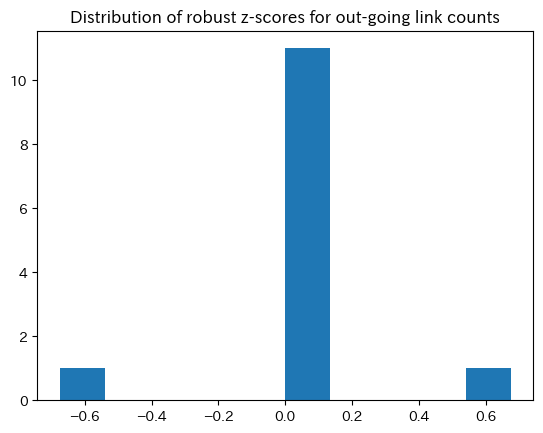

In [23]:
## check robust z-score distribution
import matplotlib.pyplot as plt
plt.hist(M.robust_zscores_from_sources.values(), bins = 10)
plt.title(f"Distribution of robust z-scores for out-going link counts")
plt.show()

In [24]:
## calculate z-scores from link sources
plb.gen_zscores_from_sources_by(p_metric, M, gap_mark = gap_mark, tracer = tracer, use_robust_zscore = False)

#source   0: ('_',) has 1 out-link(s) at rank 0 [z-score: -1.000]
#source   1: ('_', '_') has 78 out-link(s) at rank 0 [z-score: 1.000]
#source   2: ('_', 'in') has 2 out-link(s) at rank 1 [z-score: 0.000]
#source   3: ('s', '_') has 1 out-link(s) at rank 1 [z-score: 0.000]
#source   4: ('p', '_') has 1 out-link(s) at rank 1 [z-score: 0.000]
#source   5: ('_', 'un') has 1 out-link(s) at rank 1 [z-score: 0.000]
#source   6: ('_', 'ud') has 4 out-link(s) at rank 1 [z-score: 0.000]
#source   7: ('m', '_') has 1 out-link(s) at rank 1 [z-score: 0.000]
#source   8: ('pi', '_') has 1 out-link(s) at rank 1 [z-score: 0.000]
#source   9: ('_', 'n') has 1 out-link(s) at rank 1 [z-score: 0.000]
#source  10: ('b', '_') has 1 out-link(s) at rank 1 [z-score: 0.000]
#source  11: ('_', 'an') has 1 out-link(s) at rank 1 [z-score: 0.000]
#source  12: ('f', '_') has 1 out-link(s) at rank 1 [z-score: 0.000]


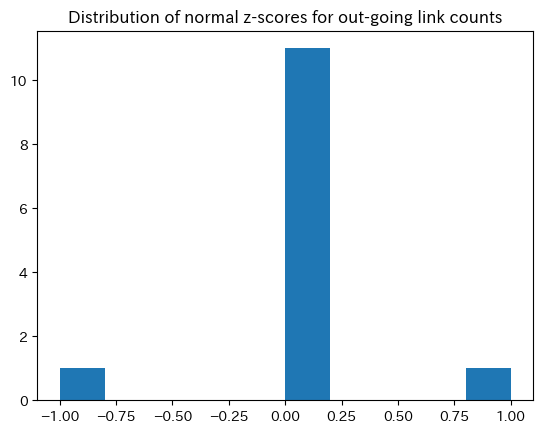

In [25]:
## check normal z-score distribution
import matplotlib.pyplot as plt
plt.hist(M.zscores_from_sources.values(), bins = 10)
plt.title(f"Distribution of normal z-scores for out-going link counts")
plt.show()

In [26]:
## calculate z-scores from link targets
plb.gen_zscores_from_targets_by (p_metric, M, gap_mark = gap_mark, tracer = tracer, use_robust_zscore = True)

#target   0: ('in',) has 2 in-link(s) at rank 1 [z-score: 0.000]
#target   1: ('_',) has 6 in-link(s) at rank 0 [z-score: 0.000]
#target   2: ('_', 'in') has 6 in-link(s) at rank 1 [z-score: 0.000]
#target   3: ('_', 'an') has 6 in-link(s) at rank 1 [z-score: 0.000]
#target   4: ('b', '_') has 6 in-link(s) at rank 1 [z-score: 0.000]
#target   5: ('p', '_') has 6 in-link(s) at rank 1 [z-score: 0.000]
#target   6: ('pi', '_') has 6 in-link(s) at rank 1 [z-score: 0.000]
#target   7: ('_', 'ud') has 12 in-link(s) at rank 1 [z-score: 0.000]
#target   8: ('_', 'un') has 6 in-link(s) at rank 1 [z-score: 0.000]
#target   9: ('m', '_') has 6 in-link(s) at rank 1 [z-score: 0.000]
#target  10: ('f', '_') has 6 in-link(s) at rank 1 [z-score: 0.000]
#target  11: ('_', 'n') has 6 in-link(s) at rank 1 [z-score: 0.000]
#target  12: ('s', '_') has 6 in-link(s) at rank 1 [z-score: 0.000]
#target  13: ('s', 'in') has 2 in-link(s) at rank 2 [z-score: 0.000]
#target  14: ('p', 'un') has 2 in-link(s) at ran

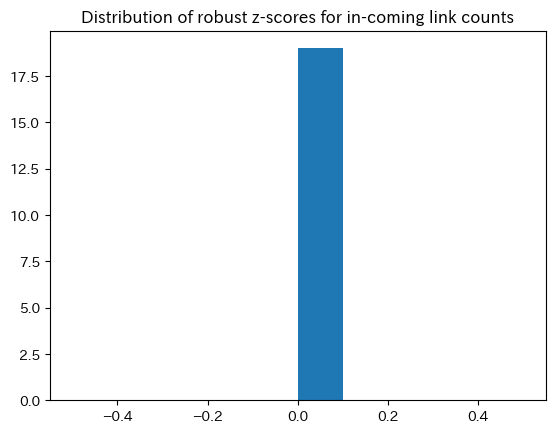

In [27]:
## check z-score distribution
import matplotlib.pyplot as plt
plt.hist(M.robust_zscores_from_targets.values(), bins = 10)
plt.title(f"Distribution of robust z-scores for in-coming link counts")
plt.show()

In [28]:
## calculate z-scores from link targets
plb.gen_zscores_from_targets_by(p_metric, M, gap_mark = gap_mark, tracer = tracer, use_robust_zscore = False)

#target   0: ('in',) has 2 in-link(s) at rank 1 [z-score: 0.000]
#target   1: ('_',) has 6 in-link(s) at rank 0 [z-score: 0.000]
#target   2: ('_', 'in') has 6 in-link(s) at rank 1 [z-score: 0.000]
#target   3: ('_', 'an') has 6 in-link(s) at rank 1 [z-score: 0.000]
#target   4: ('b', '_') has 6 in-link(s) at rank 1 [z-score: 0.000]
#target   5: ('p', '_') has 6 in-link(s) at rank 1 [z-score: 0.000]
#target   6: ('pi', '_') has 6 in-link(s) at rank 1 [z-score: 0.000]
#target   7: ('_', 'ud') has 12 in-link(s) at rank 1 [z-score: 0.000]
#target   8: ('_', 'un') has 6 in-link(s) at rank 1 [z-score: 0.000]
#target   9: ('m', '_') has 6 in-link(s) at rank 1 [z-score: 0.000]
#target  10: ('f', '_') has 6 in-link(s) at rank 1 [z-score: 0.000]
#target  11: ('_', 'n') has 6 in-link(s) at rank 1 [z-score: 0.000]
#target  12: ('s', '_') has 6 in-link(s) at rank 1 [z-score: 0.000]
#target  13: ('s', 'in') has 2 in-link(s) at rank 2 [z-score: 0.000]
#target  14: ('p', 'un') has 2 in-link(s) at ran

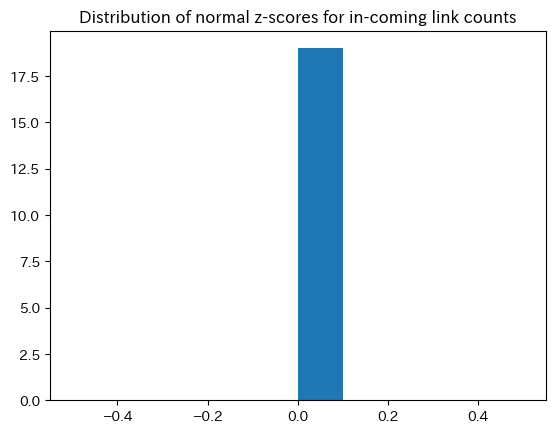

In [29]:
## check z-score distribution
import matplotlib.pyplot as plt
plt.hist(M.zscores_from_targets.values(), bins = 10)
plt.title(f"Distribution of normal z-scores for in-coming link counts")
plt.show()

In [30]:
## select z-score base
if zscores_from_targets:
    if use_robust_zscore:
        Link_bases = M.target_robust_zscores
        print(f"robust z-scores are obtained from link_targets")
    else:
        Link_bases = M.target_zscores
        print(f"z-scores are obtained from link_targets")
else:
    if use_robust_zscore:
        Link_bases = M.source_robust_zscores
        print(f"robust zscores are obtained from link_sources")
    else:
        Link_bases = M.source_zscores
        print(f"zscores are obtained from link_sources")

robust zscores are obtained from link_sources


In [31]:
## check result
i = 0
for key, value in Link_bases.items():
    i += 1
    print(f"node {i:3d} {key} has z-score: {value: .4f}")

node   1 ('_',) has z-score: -0.6745
node   2 ('_', '_') has z-score:  0.6745
node   3 ('_', 'in') has z-score:  0.0000
node   4 ('s', '_') has z-score:  0.0000
node   5 ('p', '_') has z-score:  0.0000
node   6 ('_', 'un') has z-score:  0.0000
node   7 ('_', 'ud') has z-score:  0.0000
node   8 ('m', '_') has z-score:  0.0000
node   9 ('pi', '_') has z-score:  0.0000
node  10 ('_', 'n') has z-score:  0.0000
node  11 ('b', '_') has z-score:  0.0000
node  12 ('_', 'an') has z-score:  0.0000
node  13 ('f', '_') has z-score:  0.0000


In [32]:
## draw a pruned diagram from the merged lattice
graph_layouts = [   'Multi_partite', # 0
                    'Graphviz', # 1
                    'ARF', # 2
                    'Fruchterman_Reingold', # 3
                    'Kamada_Kawai', # 4
                    'Spring', # 5
                    'Shell', # 6
                    'Spectral', # 7
                    'Circular', # 8
                    'Planar' # 9 # often fails
                 ]
##
layout             = graph_layouts[0]
scale_factor       = 3
zscore_lowerbound  = -0.0
zscore_upperbound  = None

#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned/ignored 7 nodes
#n_instances: 7
#max_instance_n_segs: 2
#max_instance_size: 3
#fig_size: None
#label_size: 8
#node_size: 9
#instance_labels 7: ['in', 's, in', 'p, un', '…', 'f, an']


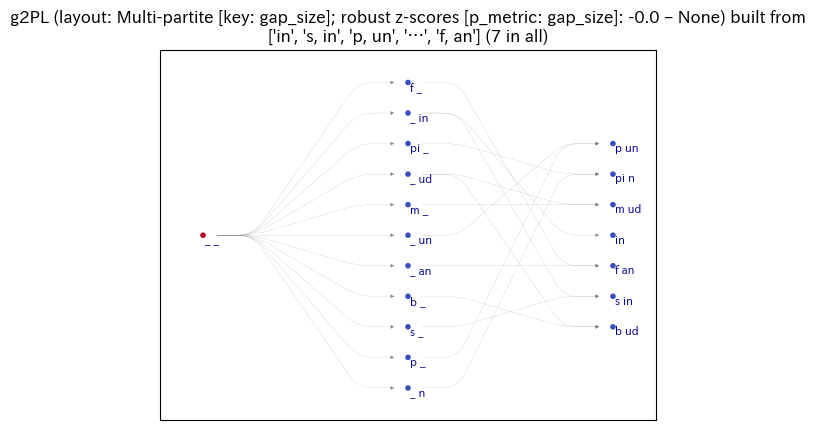

#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned/ignored 7 nodes
#n_instances: 7
#max_instance_n_segs: 2
#max_instance_size: 3
#fig_size: None
#label_size: 8
#node_size: 9
#instance_labels 7: ['in', 's, in', 'p, un', '…', 'f, an']


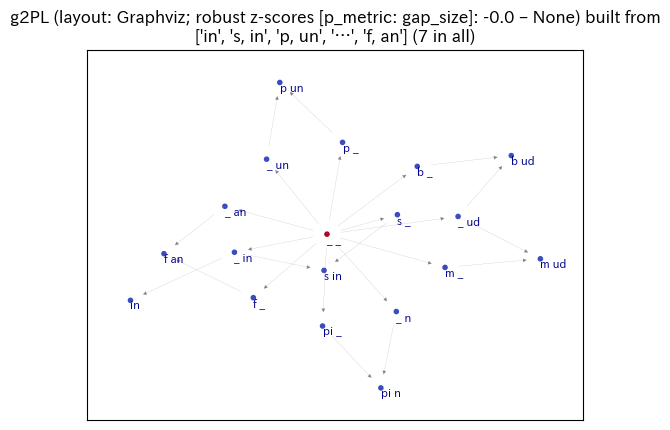

#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned/ignored 7 nodes
#n_instances: 7
#max_instance_n_segs: 2
#max_instance_size: 3
#fig_size: None
#label_size: 8
#node_size: 9
#instance_labels 7: ['in', 's, in', 'p, un', '…', 'f, an']


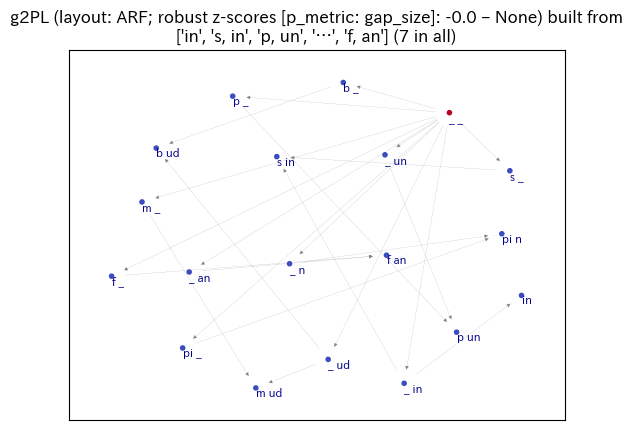

#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned/ignored 7 nodes
#n_instances: 7
#max_instance_n_segs: 2
#max_instance_size: 3
#fig_size: None
#label_size: 8
#node_size: 9
#instance_labels 7: ['in', 's, in', 'p, un', '…', 'f, an']


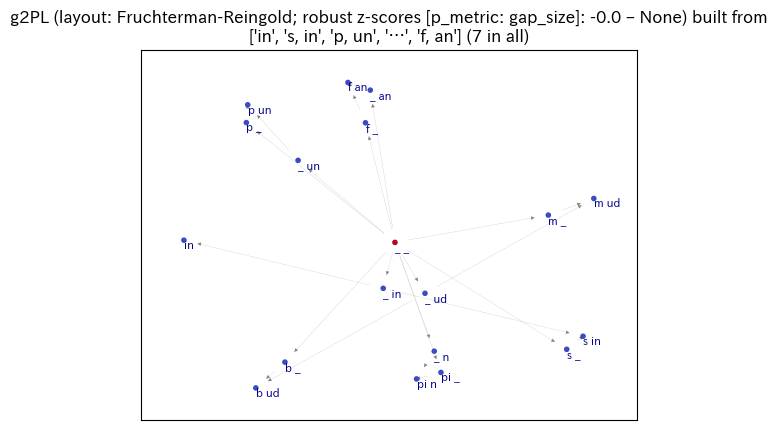

#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned/ignored 7 nodes
#n_instances: 7
#max_instance_n_segs: 2
#max_instance_size: 3
#fig_size: None
#label_size: 8
#node_size: 9
#instance_labels 7: ['in', 's, in', 'p, un', '…', 'f, an']


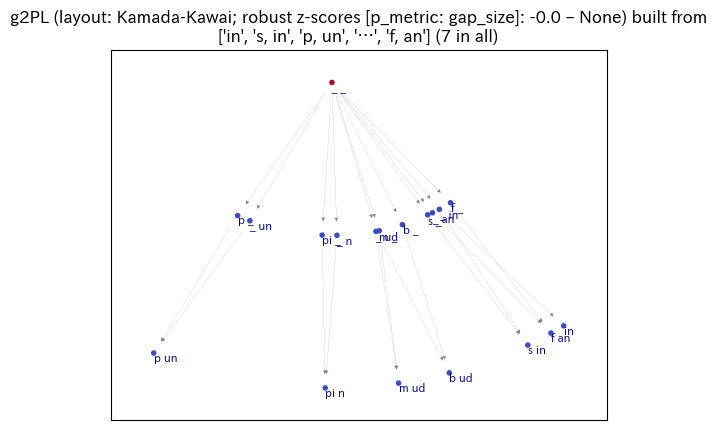

#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned/ignored 7 nodes
#n_instances: 7
#max_instance_n_segs: 2
#max_instance_size: 3
#fig_size: None
#label_size: 8
#node_size: 9
#instance_labels 7: ['in', 's, in', 'p, un', '…', 'f, an']


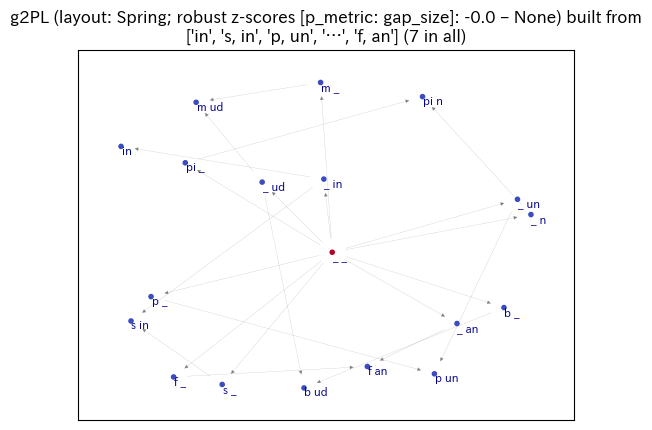

#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned/ignored 7 nodes
#n_instances: 7
#max_instance_n_segs: 2
#max_instance_size: 3
#fig_size: None
#label_size: 8
#node_size: 9
#instance_labels 7: ['in', 's, in', 'p, un', '…', 'f, an']


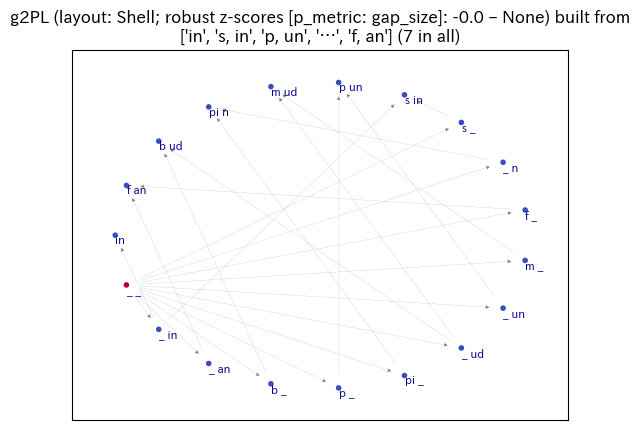

#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned/ignored 7 nodes
#n_instances: 7
#max_instance_n_segs: 2
#max_instance_size: 3
#fig_size: None
#label_size: 8
#node_size: 9
#instance_labels 7: ['in', 's, in', 'p, un', '…', 'f, an']


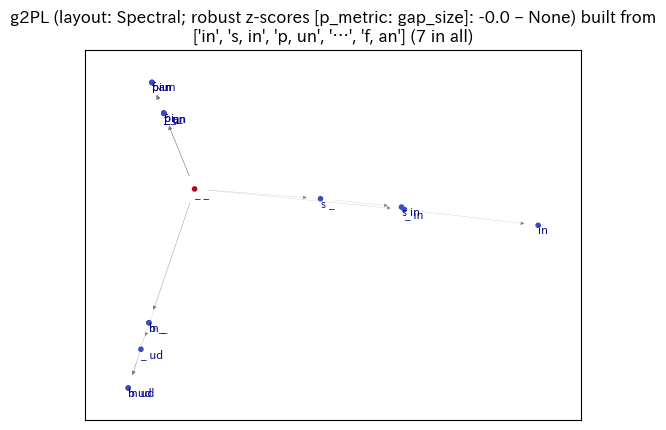

#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned/ignored 7 nodes
#n_instances: 7
#max_instance_n_segs: 2
#max_instance_size: 3
#fig_size: None
#label_size: 8
#node_size: 9
#instance_labels 7: ['in', 's, in', 'p, un', '…', 'f, an']


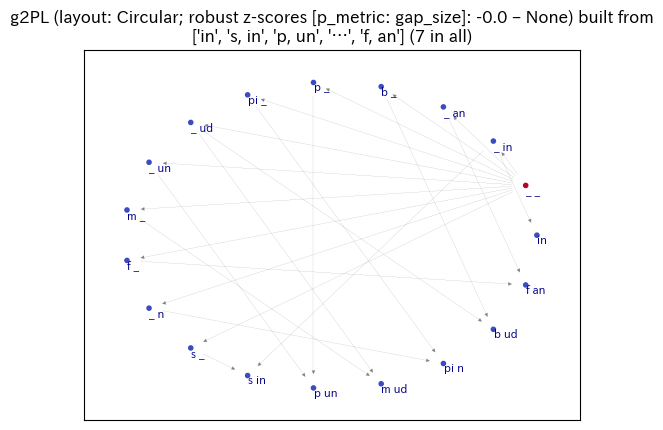

#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned node ('_',)
#pruned/ignored 7 nodes
#n_instances: 7
#max_instance_n_segs: 2
#max_instance_size: 3
#fig_size: None
#label_size: 8
#node_size: 9
#instance_labels 7: ['in', 's, in', 'p, un', '…', 'f, an']


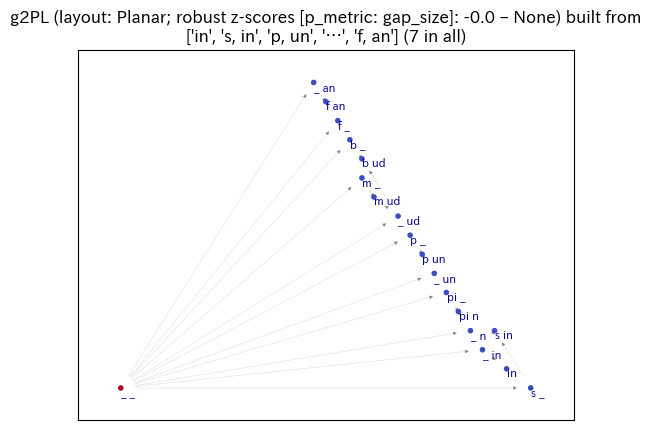

In [34]:
for layout in graph_layouts:
   M.draw_lattice (layout, MPG_key, draw_inline = draw_inline, generality = generality, zscores_from_targets = zscores_from_targets, auto_figsizing = False, label_sample_n = 4, zscore_lb = zscore_lowerbound, zscore_ub = zscore_upperbound, scale_factor = scale_factor, graphics_backend = 'gt', font_name = multibyte_font_name, check = False)